In [1]:
!nvidia-smi

Fri Nov 25 03:01:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   25C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers datasets --quiet

     |████████████████████████████████| 5.5 MB 16.4 MB/s 
     |████████████████████████████████| 451 kB 72.8 MB/s 
     |████████████████████████████████| 182 kB 86.8 MB/s 
     |████████████████████████████████| 7.6 MB 74.5 MB/s 
     |████████████████████████████████| 212 kB 82.9 MB/s 
     |████████████████████████████████| 115 kB 89.2 MB/s 
     |████████████████████████████████| 127 kB 87.4 MB/s 


In [3]:
#@title Imports
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt

import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

import glob 

import pickle

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle

In [5]:
#@title Load Data
imdb_dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
split_lengths = [len(imdb_dataset[split])for split in imdb_dataset]

print(f"Split lengths: {split_lengths}")
print(f"Features: {imdb_dataset['train'].column_names}")

Split lengths: [25000, 25000, 50000]
Features: ['text', 'label']


## Load Data

In [7]:
#@title Create DataFrame
imdb_train_df = pd.DataFrame(imdb_dataset['train'])
print(imdb_train_df.shape)
imdb_train_df.head()

(25000, 2)


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [8]:
import os
import glob

In [9]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
!ls gdrive/MyDrive/amazon_summaries

finetuned_imdb_amazon_summary.csv  imdb_amazon_summary.csv  test_data


#### Import Pegasus Data

In [11]:
!ls gdrive/MyDrive/imdb_summaries/

imdb_summary_100.csv  imdb_summary_18.csv  imdb_summary_5.csv
imdb_summary_101.csv  imdb_summary_19.csv  imdb_summary_60.csv
imdb_summary_102.csv  imdb_summary_1.csv   imdb_summary_61.csv
imdb_summary_103.csv  imdb_summary_20.csv  imdb_summary_62.csv
imdb_summary_104.csv  imdb_summary_21.csv  imdb_summary_63.csv
imdb_summary_105.csv  imdb_summary_22.csv  imdb_summary_64.csv
imdb_summary_106.csv  imdb_summary_23.csv  imdb_summary_65.csv
imdb_summary_107.csv  imdb_summary_24.csv  imdb_summary_66.csv
imdb_summary_108.csv  imdb_summary_25.csv  imdb_summary_67.csv
imdb_summary_109.csv  imdb_summary_26.csv  imdb_summary_68.csv
imdb_summary_10.csv   imdb_summary_27.csv  imdb_summary_69.csv
imdb_summary_110.csv  imdb_summary_28.csv  imdb_summary_6.csv
imdb_summary_111.csv  imdb_summary_29.csv  imdb_summary_70.csv
imdb_summary_112.csv  imdb_summary_2.csv   imdb_summary_71.csv
imdb_summary_113.csv  imdb_summary_30.csv  imdb_summary_72.csv
imdb_summary_114.csv  imdb_summary_31.csv  imdb_summary_7

In [12]:
files = os.path.join('/content/gdrive/MyDrive/imdb_summaries/', 'imdb_summary_*.csv')
files = glob.glob(files)

In [13]:
#@title Create Pegasus DF
pegasus_df = pd.concat(map(pd.read_csv, files), ignore_index = True)

In [14]:
#@title Create Pegasus Amazon DF
pegasus_amazon_df = pd.read_csv('gdrive/MyDrive/amazon_summaries/imdb_amazon_summary.csv')

In [15]:
#@title Create Pegasus Amazon FineTune DF
pft_amazon_df = pd.read_csv('gdrive/MyDrive/amazon_summaries/finetuned_imdb_amazon_summary.csv')

In [16]:
#@title Merge Pegasus DF
merge_df = pd.merge(imdb_train_df, pegasus_df, left_index=True, right_index=True)
merge_df = merge_df.drop(['Unnamed: 0'], axis=1)
merge_df = merge_df.rename(columns={"summary": "pegasus_summary"})
merge_df.head()

,text,label,pegasus_summary
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,I AM CURIOUS is a film that has been viewed by...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,"Chloe Rigny's new film is a ""damning indictmen..."
2,If only to avoid making this type of film in t...,0,A film about a tree growing in the middle of n...
3,This film was probably inspired by Godard's Ma...,0,"The film is a farce, but it's not as bad or st..."
4,"Oh, brother...after hearing about this ridicul...",0,"I'm not sure what happened to the film, but it..."


In [17]:
#@title Merge Amazon Pegasus DF
merge_df = pd.merge(merge_df, pegasus_amazon_df, left_index=True, right_index=True)
merge_df = merge_df.drop(['Unnamed: 0'], axis=1)
merge_df = merge_df.rename(columns={"summary": "pegasus_amazon_summary"})
merge_df.head()

,text,label,pegasus_summary,pegasus_amazon_summary
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,I AM CURIOUS is a film that has been viewed by...,I AM CURIOUS-YELLOW is a good film for anyone ...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,"Chloe Rigny's new film is a ""damning indictmen...","""I Am Curious: Yellow"" is a risible and preten..."
2,If only to avoid making this type of film in t...,0,A film about a tree growing in the middle of n...,One of the worst films I've seen in a long tim...
3,This film was probably inspired by Godard's Ma...,0,"The film is a farce, but it's not as bad or st...","A movie of its time, and place. A movie of its..."
4,"Oh, brother...after hearing about this ridicul...",0,"I'm not sure what happened to the film, but it...","Oh, brother...after hearing about this ridicul..."


In [18]:
#@title Merge Amazon Finetuned Pegasus DF
merge_df = pd.merge(merge_df, pft_amazon_df, left_index=True, right_index=True)
merge_df = merge_df.drop(['Unnamed: 0'], axis=1)
merge_df = merge_df.rename(columns={"summary": "finetuned_pegasus_amazon_summary"})
merge_df.head()

,text,label,pegasus_summary,pegasus_amazon_summary,finetuned_pegasus_amazon_summary
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,I AM CURIOUS is a film that has been viewed by...,I AM CURIOUS-YELLOW is a good film for anyone ...,I AM CURIOUS-YELLOW is a good film for anyone ...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,"Chloe Rigny's new film is a ""damning indictmen...","""I Am Curious: Yellow"" is a risible and preten...",risible and pretentious steaming pile. It does...
2,If only to avoid making this type of film in t...,0,A film about a tree growing in the middle of n...,One of the worst films I've seen in a long tim...,This film is interesting as an experiment but ...
3,This film was probably inspired by Godard's Ma...,0,"The film is a farce, but it's not as bad or st...","A movie of its time, and place. A movie of its...",This film was probably inspired by Godard's Ma...
4,"Oh, brother...after hearing about this ridicul...",0,"I'm not sure what happened to the film, but it...","Oh, brother...after hearing about this ridicul...","Oh, brother...after hearing about this ridicul..."


In [19]:
merge_df = merge_df[:17500]

In [20]:
#@title Split to train and validation sets
train, val = train_test_split(merge_df, test_size=0.2, random_state=2022, shuffle=True)

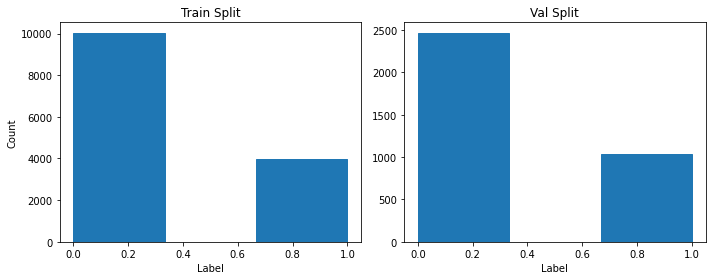

In [21]:
#@title Review Split Labels
train_split = [s for s in train['label']]

val_split = [s for s in val['label']]
# review_len = [len(s) for s in dataset_amazon['train'][:10000]['review_body']]

# headline_len = [len(s) for s in dataset_amazon['train'][:10000]['review_headline']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='none' )
axes[0].hist(train_split, bins = 3, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Train Split")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Count")

axes[1].hist(val_split, bins = 3, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Val Split")
axes[1].set_xlabel("Label")
plt.tight_layout()
plt.show()

In [31]:
train_label_1_df = train[train['label']==1]

In [33]:
len(train_label_1_df)

3967

In [34]:
len(train)

14000

Text(0, 0.5, 'Count')

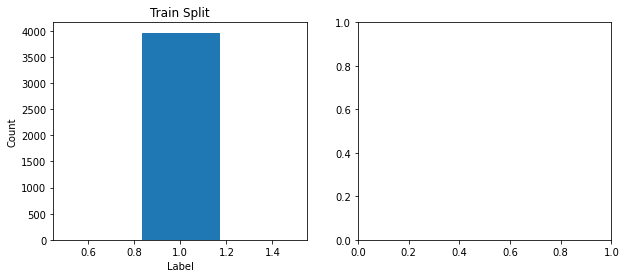

In [32]:
#@title Review Split Labels
train_split = [s for s in train_label_1_df['label']]

# val_split = [s for s in val['label']]
# review_len = [len(s) for s in dataset_amazon['train'][:10000]['review_body']]

# headline_len = [len(s) for s in dataset_amazon['train'][:10000]['review_headline']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='none' )
axes[0].hist(train_split, bins = 3, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Train Split")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Count")

# axes[1].hist(val_split, bins = 3, color = 'C0', edgecolor = 'C0' )
# axes[1].set_title("Val Split")
# axes[1].set_xlabel("Label")
# plt.tight_layout()
# plt.show()

In [35]:
oversampled_1_df = train.append(train_label_1_df)

In [36]:
len(oversampled_1_df)

17967

Text(0, 0.5, 'Count')

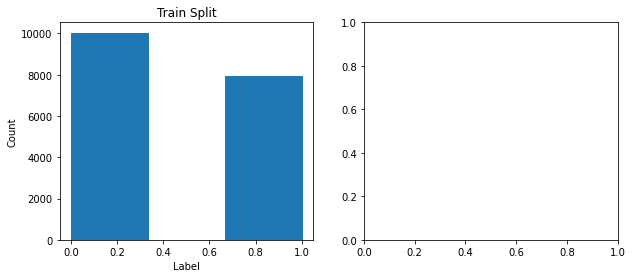

In [37]:
#@title Review Split Labels
train_split = [s for s in oversampled_1_df['label']]

# val_split = [s for s in val['label']]
# review_len = [len(s) for s in dataset_amazon['train'][:10000]['review_body']]

# headline_len = [len(s) for s in dataset_amazon['train'][:10000]['review_headline']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='none' )
axes[0].hist(train_split, bins = 3, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Train Split")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Count")

# axes[1].hist(val_split, bins = 3, color = 'C0', edgecolor = 'C0' )
# axes[1].set_title("Val Split")
# axes[1].set_xlabel("Label")
# plt.tight_layout()
# plt.show()

### Load Test Data and Summaries

In [22]:
imdb_test_df = pd.DataFrame(imdb_dataset['test'])
print(imdb_test_df.shape)
imdb_test_df.head()

(25000, 2)


,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


In [23]:
#@title Create Pegasus Test DF
pegasus_test_df = pd.read_csv('gdrive/MyDrive/amazon_summaries/test_data/imdb_test_pegasus_summary.csv')

In [24]:
#@title Create Pegasus Amazon Test DF
pegasus_amazon_test_df = pd.read_csv('gdrive/MyDrive/amazon_summaries/test_data/imdb_test_amazon_summary.csv')

In [25]:
#@title Create FT Pegasus Amazon Test DF
pft_amazon_test_df = pd.read_csv('gdrive/MyDrive/amazon_summaries/test_data/imdb_test_amazon_finetuned_summary.csv')

In [26]:
#@title Merge test and Pegasus
merge_test_df = pd.merge(imdb_test_df, pegasus_test_df, left_index=True, right_index=True)
merge_test_df = merge_test_df.drop(['Unnamed: 0'], axis=1)
merge_test_df = merge_test_df.rename(columns={"summary": "pegasus_summary"})
merge_test_df.head()

,text,label,pegasus_summary
0,I love sci-fi and am willing to put up with a ...,0,"Sci-fi movies/TV are usually underfunded, unde..."
1,"Worth the entertainment value of a rental, esp...",0,"This one features the usual car chases, fights..."
2,its a totally average film with a few semi-alr...,0,parts of the plot don't make sense and seem to...
3,STAR RATING: ***** Saturday Night **** Friday ...,0,Former New Orleans homicide cop Jack Robideaux...
4,"First off let me say, If you haven't enjoyed a...",0,"Van Damme is good in the movie, the movie is o..."


In [27]:
#@title Merge test and Amazon
merge_test_df = pd.merge(merge_test_df, pegasus_amazon_test_df, left_index=True, right_index=True)
merge_test_df = merge_test_df.drop(['Unnamed: 0'], axis=1)
merge_test_df = merge_test_df.rename(columns={"summary": "pegasus_amazon_summary"})
merge_test_df.head()

,text,label,pegasus_summary,pegasus_amazon_summary
0,I love sci-fi and am willing to put up with a ...,0,"Sci-fi movies/TV are usually underfunded, unde...",I love sci-fi and am willing to put up with a ...
1,"Worth the entertainment value of a rental, esp...",0,"This one features the usual car chases, fights...",Not bad. Not bad. Not bad. Not bad. Not bad. N...
2,its a totally average film with a few semi-alr...,0,parts of the plot don't make sense and seem to...,"not bad, not van dam's best, not worth watchin..."
3,STAR RATING: ***** Saturday Night **** Friday ...,0,Former New Orleans homicide cop Jack Robideaux...,One of Van Damme's worst films since Derailed....
4,"First off let me say, If you haven't enjoyed a...",0,"Van Damme is good in the movie, the movie is o...",Van Damme is good in this movie. It is not as ...


In [28]:
#@title Merge test and Amazon Finetuned
merge_test_df = pd.merge(merge_test_df, pft_amazon_test_df, left_index=True, right_index=True)
merge_test_df = merge_test_df.drop(['Unnamed: 0'], axis=1)
merge_test_df = merge_test_df.rename(columns={"summary": "finetuned_pegasus_amazon_summary"})
merge_test_df.head()

,text,label,pegasus_summary,pegasus_amazon_summary,finetuned_pegasus_amazon_summary
0,I love sci-fi and am willing to put up with a ...,0,"Sci-fi movies/TV are usually underfunded, unde...",I love sci-fi and am willing to put up with a ...,I love sci-fi and am willing to put up with a ...
1,"Worth the entertainment value of a rental, esp...",0,"This one features the usual car chases, fights...",Not bad. Not bad. Not bad. Not bad. Not bad. N...,"Worth the entertainment value of a rental, esp..."
2,its a totally average film with a few semi-alr...,0,parts of the plot don't make sense and seem to...,"not bad, not van dam's best, not worth watchin...",an average film with a few semi-alright action...
3,STAR RATING: ***** Saturday Night **** Friday ...,0,Former New Orleans homicide cop Jack Robideaux...,One of Van Damme's worst films since Derailed....,One of Van Damme's worst films since Derailed....
4,"First off let me say, If you haven't enjoyed a...",0,"Van Damme is good in the movie, the movie is o...",Van Damme is good in this movie. It is not as ...,Van Damme's best action movie since bloodsport...


## Sentiment Analysis

In [29]:
#@title Load Model - DistilBERT
MODEL_NAME = 'distilbert-base-uncased'
# review = x[0]

tkzr = DistilBertTokenizer.from_pretrained(MODEL_NAME)

# inputs = tkzr(review, max_length=MAX_LEN, truncation=True, padding=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [38]:
#@title Construct Encodings
MAX_LEN = 512
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tkzr(x, max_length=max_len, truncation=trucation, padding=padding)
    
# encodings = construct_encodings(x, tkzr, max_len=MAX_LEN)


#Full review encodings
train_encodings = construct_encodings(list(train['text']), tkzr, max_len=MAX_LEN)
val_encodings = construct_encodings(list(val['text']), tkzr, max_len=MAX_LEN)

# #Pegasus summary encodings
# train_pegasus_sum_encodings = construct_encodings(list(train['pegasus_summary']), tkzr, max_len=MAX_LEN)
# val_pegasus_sum_encodings = construct_encodings(list(val['pegasus_summary']), tkzr, max_len=MAX_LEN)

# #Pegasus Amazon summary encodings
# train_amazon_pegasus_sum_encodings = construct_encodings(list(train['pegasus_amazon_summary']), tkzr, max_len=MAX_LEN)
# val_amazon_pegasus_sum_encodings = construct_encodings(list(val['pegasus_amazon_summary']), tkzr, max_len=MAX_LEN)

#Pegasus Amazon Finetuned summary encodings
train_amazon_ft_pegasus_sum_encodings = construct_encodings(list(train['finetuned_pegasus_amazon_summary']), tkzr, max_len=MAX_LEN)
val_amazon_ft_pegasus_sum_encodings = construct_encodings(list(val['finetuned_pegasus_amazon_summary']), tkzr, max_len=MAX_LEN)

#oversampled encodings
#train_label_1_df
train_oversample_encodings = construct_encodings(list(train_label_1_df['text']), tkzr, max_len=MAX_LEN)
train_oversample_amazon_ft_pegasus_sum_encodings = construct_encodings(list(train_label_1_df['finetuned_pegasus_amazon_summary']), tkzr, max_len=MAX_LEN)

#Test Encodings
test_encodings = construct_encodings(list(merge_test_df['text']), tkzr, max_len=MAX_LEN)
# test_pegasus_sum_encodings = construct_encodings(list(merge_test_df['pegasus_summary']), tkzr, max_len=MAX_LEN)
# test_amazon_pegasus_sum_encodings = construct_encodings(list(merge_test_df['pegasus_amazon_summary']), tkzr, max_len=MAX_LEN)
test_amazon_ft_pegasus_sum_encodings = construct_encodings(list(merge_test_df['finetuned_pegasus_amazon_summary']), tkzr, max_len=MAX_LEN)


In [40]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

#Full Review tensors
tf_train = construct_tfdataset(train_encodings, list(train['label']))
tf_val = construct_tfdataset(val_encodings, list(val['label']))

# #Pegasus summary tensors
# tf_peg_sum_train = construct_tfdataset(train_pegasus_sum_encodings, list(train['label']))
# tf_peg_sum_val = construct_tfdataset(val_pegasus_sum_encodings, list(val['label']))

# #Pegasus Amazon summary tensors
# tf_peg_amazon_sum_train = construct_tfdataset(train_pegasus_sum_encodings, list(train['label']))
# tf_peg_amazon_sum_val = construct_tfdataset(val_pegasus_sum_encodings, list(val['label']))

#Pegasus Amazon FT summary tensors
tf_peg_amazon_ft_sum_train = construct_tfdataset(train_amazon_ft_pegasus_sum_encodings, list(train['label']))
tf_peg_amazon_ft_sum_val = construct_tfdataset(val_amazon_ft_pegasus_sum_encodings, list(val['label']))

#Oversampled summary tensors
tf_oversampled_train = construct_tfdataset(train_oversample_encodings, list(train_label_1_df['label']))
tf_oversampled_peg_amazon_ft_train = construct_tfdataset(train_oversample_amazon_ft_pegasus_sum_encodings, list(train_label_1_df['label']))

#Test Set Tensors
tf_test = construct_tfdataset(test_encodings, list(merge_test_df['label']))
# tf_peg_test = construct_tfdataset(test_pegasus_sum_encodings, list(merge_test_df['label']))
# tf_peg_amazon_test = construct_tfdataset(test_amazon_pegasus_sum_encodings, list(merge_test_df['label']))
tf_peg_amazon_ft_test = construct_tfdataset(test_amazon_ft_pegasus_sum_encodings, list(merge_test_df['label']))

In [41]:
#@title Concatenate for oversampling for resampling or with summary sample appended
# train_peg_concat_tf = tf_train.concatenate(tf_peg_sum_train)
# train_pa_concat_tf = tf_train.concatenate(tf_peg_amazon_sum_train)
#this one is still imbalanced
train_pa_ft_concat_tf = tf_train.concatenate(tf_peg_amazon_ft_sum_train)

#resampling
train_resampled_tf = tf_train.concatenate(tf_oversampled_train)

#summary sampling augmentation
train_augmented_tf = tf_train.concatenate(tf_oversampled_peg_amazon_ft_train)


In [42]:
#@title Batch tensors
BATCH_SIZE = 16
#Training and Validation sets
tf_train = tf_train.batch(BATCH_SIZE)
tf_val = tf_val.batch(BATCH_SIZE)

# tf_peg_sum_train = tf_peg_sum_train.batch(BATCH_SIZE)
# tf_peg_sum_val = tf_peg_sum_val.batch(BATCH_SIZE)

# tf_peg_amazon_sum_train = tf_peg_amazon_sum_train.batch(BATCH_SIZE)
# tf_peg_amazon_sum_val = tf_peg_amazon_sum_val.batch(BATCH_SIZE)

tf_peg_amazon_ft_sum_train = tf_peg_amazon_ft_sum_train.batch(BATCH_SIZE)
tf_peg_amazon_ft_sum_val = tf_peg_amazon_ft_sum_val.batch(BATCH_SIZE)

#Concatenated train review + summary
# train_peg_concat_tf = train_peg_concat_tf.batch(BATCH_SIZE)
# train_pa_concat_tf = train_pa_concat_tf.batch(BATCH_SIZE)
train_pa_ft_concat_tf = train_pa_ft_concat_tf.batch(BATCH_SIZE)
train_resampled_tf = train_resampled_tf.batch(BATCH_SIZE)
train_augmented_tf = train_augmented_tf.batch(BATCH_SIZE)

#Test sets
tf_test = tf_test.batch(BATCH_SIZE)
# tf_peg_test = tf_peg_test.batch(BATCH_SIZE)
# tf_peg_amazon_test = tf_peg_amazon_test.batch(BATCH_SIZE)
tf_peg_amazon_ft_test = tf_peg_amazon_ft_test.batch(BATCH_SIZE)

## Training Models

#### Full Reviews

In [43]:
#@title Train on full reviews
N_EPOCHS = 5

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(tf_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
875/875 [==============================] - 115s 118ms/step - loss: 0.2414 - accuracy: 0.9014
Epoch 2/5
875/875 [==============================] - 103s 118ms/step - loss: 0.1159 - accuracy: 0.9581
Epoch 3/5
875/875 [==============================] - 103s 118ms/step - loss: 0.0632 - accuracy: 0.9779
Epoch 4/5
875/875 [==============================] - 103s 118ms/step - loss: 0.0395 - accuracy: 0.9867
Epoch 5/5
875/875 [==============================] - 103s 118ms/step - loss: 0.0297 - accuracy: 0.9901


In [44]:
#@title Save the model
filename = 'gdrive/MyDrive/SA_models/imbalanced_full_review_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [45]:
#@title Validation set Full review Baseline
benchmarks = model.evaluate(tf_val, return_dict=True, batch_size=BATCH_SIZE)
print(benchmarks)

219/219 [==============================] - 11s 41ms/step - loss: 0.2804 - accuracy: 0.9240
{'loss': 0.2804030776023865, 'accuracy': 0.9240000247955322}


In [46]:
#@title Validate against Pegasus Amazon FT Summary
full_peg_amazon_ft_sum_benchmarks = model.evaluate(tf_peg_amazon_ft_sum_val, return_dict=True, batch_size=BATCH_SIZE)
print(full_peg_amazon_ft_sum_benchmarks)

219/219 [==============================] - 9s 42ms/step - loss: 0.5973 - accuracy: 0.8497
{'loss': 0.5973331928253174, 'accuracy': 0.8497142791748047}


#### Pegasus Amazon Finetuned Summary Model

In [47]:
#@title Train Pegasus Amazon Finetune Model
N_EPOCHS = 5

peg_amazon_ft_sum_model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
peg_amazon_ft_sum_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

peg_amazon_ft_sum_model.fit(tf_peg_amazon_ft_sum_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_39', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
875/875 [==============================] - 113s 119ms/step - loss: 0.3061 - accuracy: 0.8752
Epoch 2/5
875/875 [==============================] - 104s 119ms/step - loss: 0.1867 - accuracy: 0.9304
Epoch 3/5
875/875 [==============================] - 104s 119ms/step - loss: 0.1067 - accuracy: 0.9630
Epoch 4/5
875/875 [==============================] - 104s 119ms/step - loss: 0.0788 - accuracy: 0.9731
Epoch 5/5
875/875 [==============================] - 104s 119ms/step - loss: 0.0558 - accuracy: 0.9824


In [48]:
#@title Save the Pegasus Amazon Finetuned model
filename = 'gdrive/MyDrive/SA_models/imbalanced_peg_amazon_ft_summary_model.sav'
pickle.dump(peg_amazon_ft_sum_model, open(filename, 'wb'))

In [49]:
#@title Validate against full reviews
peg_amazon_ft_sum_full_benchmarks = peg_amazon_ft_sum_model.evaluate(tf_val, return_dict=True, batch_size=BATCH_SIZE)
print(peg_amazon_ft_sum_full_benchmarks)

219/219 [==============================] - 11s 42ms/step - loss: 0.9343 - accuracy: 0.8163
{'loss': 0.9343200922012329, 'accuracy': 0.8162857294082642}


In [50]:
#@title Validate against Pegasus Amazon Finetune summary validation
peg_amazon_ft_sum_benchmarks = peg_amazon_ft_sum_model.evaluate(tf_peg_amazon_ft_sum_val, return_dict=True, batch_size=BATCH_SIZE)
print(peg_amazon_ft_sum_benchmarks)

219/219 [==============================] - 9s 42ms/step - loss: 0.5215 - accuracy: 0.8800
{'loss': 0.521478533744812, 'accuracy': 0.8799999952316284}


#### Concatenated Summaries

##### Pegasus Amazon Finetuned Full Concat

In [51]:
#@title Concatenated Full and Pegasus Amazon Summary Train
N_EPOCHS = 5

concat_peg_am_ft_model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
concat_peg_am_ft_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

concat_peg_am_ft_model.fit(train_pa_ft_concat_tf, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_59', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
1750/1750 [==============================] - 215s 118ms/step - loss: 0.2517 - accuracy: 0.8971
Epoch 2/5
1750/1750 [==============================] - 207s 118ms/step - loss: 0.1318 - accuracy: 0.9521
Epoch 3/5
1750/1750 [==============================] - 207s 118ms/step - loss: 0.0665 - accuracy: 0.9782
Epoch 4/5
1750/1750 [==============================] - 207s 118ms/step - loss: 0.0442 - accuracy: 0.9854
Epoch 5/5
1750/1750 [==============================] - 207s 118ms/step - loss: 0.0350 - accuracy: 0.9888


In [52]:
#@title Save the Concat Pegasus Full model
filename = 'gdrive/MyDrive/SA_models/imbalanced_concat_peg_amazon_ft_full_summary_model.sav'
pickle.dump(concat_peg_am_ft_model, open(filename, 'wb'))

In [53]:
#@title Validate concat against full
concat_peg_am_ft_full_benchmarks = concat_peg_am_ft_model.evaluate(tf_val, return_dict=True, batch_size=BATCH_SIZE)
print(concat_peg_am_ft_full_benchmarks)

219/219 [==============================] - 11s 42ms/step - loss: 0.3378 - accuracy: 0.9171
{'loss': 0.33781182765960693, 'accuracy': 0.9171428680419922}


In [54]:
#@title Validate against summary
concat_peg_am_ft_sum_benchmarks = concat_peg_am_ft_model.evaluate(tf_peg_amazon_ft_sum_val, return_dict=True, batch_size=BATCH_SIZE)
print(concat_peg_am_ft_sum_benchmarks)

219/219 [==============================] - 9s 42ms/step - loss: 0.4716 - accuracy: 0.8889
{'loss': 0.47160986065864563, 'accuracy': 0.8888571262359619}


##### Resampled Concat

In [55]:
#@title Resampled model
N_EPOCHS = 5

resampled_model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
resampled_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

resampled_model.fit(train_resampled_tf, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_79', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
1123/1123 [==============================] - 142s 118ms/step - loss: 0.1903 - accuracy: 0.9228
Epoch 2/5
1123/1123 [==============================] - 133s 118ms/step - loss: 0.1171 - accuracy: 0.9599
Epoch 3/5
1123/1123 [==============================] - 132s 118ms/step - loss: 0.0638 - accuracy: 0.9799
Epoch 4/5
1123/1123 [==============================] - 133s 118ms/step - loss: 0.0386 - accuracy: 0.9871
Epoch 5/5
1123/1123 [==============================] - 132s 118ms/step - loss: 0.0200 - accuracy: 0.9939


In [56]:
#@title Save the resampled model
filename = 'gdrive/MyDrive/SA_models/imbalanced_resampled.sav'
pickle.dump(concat_peg_am_ft_model, open(filename, 'wb'))

In [57]:
#@title Validate concat against full
resampled_benchmarks = resampled_model.evaluate(tf_val, return_dict=True, batch_size=BATCH_SIZE)
print(resampled_benchmarks)

219/219 [==============================] - 12s 41ms/step - loss: 0.7031 - accuracy: 0.8689
{'loss': 0.7031193375587463, 'accuracy': 0.8688571453094482}


In [58]:
#@title Validate against summary
resampled_sum_benchmarks = resampled_model.evaluate(tf_peg_amazon_ft_sum_val, return_dict=True, batch_size=BATCH_SIZE)
print(resampled_sum_benchmarks)

219/219 [==============================] - 9s 42ms/step - loss: 1.2041 - accuracy: 0.7743
{'loss': 1.2041324377059937, 'accuracy': 0.7742857336997986}


##### Augmented Concat

In [59]:
#@title Augmented Dataset
N_EPOCHS = 5

augmented_model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
augmented_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

augmented_model.fit(train_augmented_tf, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_99', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
1123/1123 [==============================] - 141s 118ms/step - loss: 0.1910 - accuracy: 0.9232
Epoch 2/5
1123/1123 [==============================] - 133s 118ms/step - loss: 0.1138 - accuracy: 0.9596
Epoch 3/5
1123/1123 [==============================] - 133s 118ms/step - loss: 0.0600 - accuracy: 0.9809
Epoch 4/5
1123/1123 [==============================] - 133s 118ms/step - loss: 0.0388 - accuracy: 0.9881
Epoch 5/5
1123/1123 [==============================] - 133s 118ms/step - loss: 0.0286 - accuracy: 0.9911


In [60]:
#@title Save the Augmented
filename = 'gdrive/MyDrive/SA_models/imbalanced_augmented.sav'
pickle.dump(concat_peg_am_ft_model, open(filename, 'wb'))

In [61]:
#@title Validate concat against full
augmented_benchmarks = augmented_model.evaluate(tf_val, return_dict=True, batch_size=BATCH_SIZE)
print(augmented_benchmarks)

219/219 [==============================] - 11s 42ms/step - loss: 1.4564 - accuracy: 0.7020
{'loss': 1.45643150806427, 'accuracy': 0.7020000219345093}


In [62]:
#@title Validate against summary
augmented_sum_benchmarks = augmented_model.evaluate(tf_peg_amazon_ft_sum_val, return_dict=True, batch_size=BATCH_SIZE)
print(augmented_sum_benchmarks)

219/219 [==============================] - 9s 42ms/step - loss: 4.7324 - accuracy: 0.3594
{'loss': 4.7323689460754395, 'accuracy': 0.3594285845756531}


## Sentiment Analysis Test

#### Full Train

In [63]:
#@title Full Train on Full Test
test_benchmarks = model.evaluate(tf_test, return_dict=True, batch_size=BATCH_SIZE)
print(test_benchmarks)

1563/1563 [==============================] - 64s 41ms/step - loss: 0.4090 - accuracy: 0.8964
{'loss': 0.409038782119751, 'accuracy': 0.8964400291442871}


In [64]:
#@title Full Train on Pegasus Amazon FT Test
test_peg_am_ft_benchmarks = model.evaluate(tf_peg_amazon_ft_test, return_dict=True, batch_size=BATCH_SIZE)
print(test_peg_am_ft_benchmarks)

1563/1563 [==============================] - 64s 41ms/step - loss: 0.5987 - accuracy: 0.8526
{'loss': 0.5987066626548767, 'accuracy': 0.8525599837303162}


#### Pegasus Amazon Fine Tuned Test

In [65]:
#@title Pegasus Amazon FT on Full Reviews
test_peg_am_ft_sum_benchmarks = peg_amazon_ft_sum_model.evaluate(tf_test, return_dict=True, batch_size=BATCH_SIZE)
print(test_peg_am_ft_sum_benchmarks)

1563/1563 [==============================] - 64s 41ms/step - loss: 1.7298 - accuracy: 0.6676
{'loss': 1.7297511100769043, 'accuracy': 0.667639970779419}


In [66]:
#@title Pegasus Amazon FT on Pegasus Amazon FT Reviews
test_peg_am_ft_sum_sum_benchmarks = peg_amazon_ft_sum_model.evaluate(tf_peg_amazon_ft_test, return_dict=True, batch_size=BATCH_SIZE)
print(test_peg_am_ft_sum_sum_benchmarks)

1563/1563 [==============================] - 65s 41ms/step - loss: 0.8815 - accuracy: 0.8018
{'loss': 0.8815405368804932, 'accuracy': 0.8018400073051453}


### Concatenated Datasets

#### Pegasus Amazon FT Concat

In [67]:
#@title Pegasus Amazon FT Concat Full on Full Reviews
test_concat_peg_am_ft_benchmarks = concat_peg_am_ft_model.evaluate(tf_test, return_dict=True, batch_size=BATCH_SIZE)
print(test_concat_peg_am_ft_benchmarks)

1563/1563 [==============================] - 64s 41ms/step - loss: 0.7511 - accuracy: 0.8242
{'loss': 0.7510697841644287, 'accuracy': 0.8242400288581848}


In [68]:
#@title Pegasus Amazon Concat Full on Pegasus Amazon FT Summary Reviews
test_concat_peg_am_ft_sum_benchmarks = concat_peg_am_ft_model.evaluate(tf_peg_amazon_ft_test, return_dict=True, batch_size=BATCH_SIZE)
print(test_concat_peg_am_ft_sum_benchmarks)

1563/1563 [==============================] - 65s 41ms/step - loss: 0.7966 - accuracy: 0.8179
{'loss': 0.7966099381446838, 'accuracy': 0.8179200291633606}


#### Resampled

In [69]:
#@title Resampled
test_resampled_benchmarks = resampled_model.evaluate(tf_test, return_dict=True, batch_size=BATCH_SIZE)
print(test_resampled_benchmarks)

1563/1563 [==============================] - 64s 41ms/step - loss: 0.5569 - accuracy: 0.8923
{'loss': 0.5568817257881165, 'accuracy': 0.8923199772834778}


In [70]:
#@title Pegasus Amazon Concat Full on Pegasus Amazon FT Summary Reviews
test_resampled_sum_benchmarks = resampled_model.evaluate(tf_peg_amazon_ft_test, return_dict=True, batch_size=BATCH_SIZE)
print(test_resampled_sum_benchmarks)

1563/1563 [==============================] - 64s 41ms/step - loss: 0.9088 - accuracy: 0.8240
{'loss': 0.9088497757911682, 'accuracy': 0.82396000623703}


#### Augmented

In [71]:
#@title Resampled
test_augmented_benchmarks = augmented_model.evaluate(tf_test, return_dict=True, batch_size=BATCH_SIZE)
print(test_augmented_benchmarks)

1563/1563 [==============================] - 64s 41ms/step - loss: 1.0582 - accuracy: 0.7798
{'loss': 1.0582292079925537, 'accuracy': 0.7798399925231934}


In [72]:
#@title Pegasus Amazon Concat Full on Pegasus Amazon FT Summary Reviews
test_augmented_sum_benchmarks = augmented_model.evaluate(tf_peg_amazon_ft_test, return_dict=True, batch_size=BATCH_SIZE)
print(test_augmented_sum_benchmarks)

1563/1563 [==============================] - 65s 41ms/step - loss: 3.2399 - accuracy: 0.5550
{'loss': 3.2398810386657715, 'accuracy': 0.5550000071525574}
